In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace")
import sys
sys.path.append('.')
%autosave 60

Autosaving every 60 seconds


In [ ]:
!pwd

/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace


In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 669 kB 7.6 MB/s 


In [ ]:
import numpy as np
pixel_mean = np.array([123.675, 116.280, 103.530]).reshape((1, 1, 3))
pixel_std = np.array([58.395, 57.120, 57.375]).reshape((1, 1, 3))
max_depth_range = 2.1
n_planes_for_train = 5
n_planes_for_val = 20
n_bins_for_plane_hrchy_sampling = 20
mesh_data_root = 'demodata'
data_h = 512
data_w = 512
crop_expand_ratio = 0.1
binvoxPathPrefix = 'demodata'
use_adaptive_sampling = False
bin_sample_replace = False
depth_range_expand_ratio = 0.1
use_masked_out_img = False
extra_mesh_data_root = None

In [ ]:
#from dataloader import CustomImageDataset
#path = '/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace'
#dataset = CustomImageDataset(csv_file=path + '/' + 'inputs.csv', n_planes_for_train=5)
#
#for i in range(1):
#  print(dataset[i][0].shape, dataset[i][1].shape)

In [ ]:
import os
import sys
import gc
import glob
import multiprocessing
import trimesh
import traceback
import skimage
import numpy as np
import matplotlib.pyplot as plt
# import meshplot as mp
from tqdm import tqdm
from PIL import Image
from scipy.ndimage.morphology import binary_erosion, distance_transform_edt
from scipy.ndimage import maximum_filter, gaussian_filter
from scipy import ndimage
from skimage import filters, transform  
import binvox_rw

import torch
from torch.utils.data import Dataset


class MeshObj:
    def __init__(self,fn, max_depth_range=None, fnroot="", binvoxPathPrefix='', extra_fnroot=None, pure_infer=False):
        self.float_type = np.float32
        arr = fn.split('/')
        self.csName = arr[-4]
        self.objID = int(arr[-3].split('_')[0])
        self.frameID = arr[-2].split('_')[0]
        self.IMAGE_SIZE = (800, 1280)
        self.fnroot = fnroot
        self.fn = self.fnroot + fn[1:]

        self.extra_fnroot = extra_fnroot
        if self.extra_fnroot is not None:
            self.extra_fn = self.extra_fnroot + fn[1:]
        else:
            self.extra_fn = None

        self.imfn = self.fnroot + '/{}/images/{}.bmp'.format(self.csName,self.frameID)
        if self.extra_fnroot is not None:
            self.depthfn = self.extra_fnroot + '/{}/depth/{}.npy'.format(self.csName,self.frameID)
            self.visfn = self.extra_fnroot + '/{}/visible/{}.npy'.format(self.csName,self.frameID)
        else:
            self.depthfn = self.fnroot + '/{}/depth/{}.npy'.format(self.csName,self.frameID)
            self.visfn = self.fnroot + '/{}/visible/{}.npy'.format(self.csName,self.frameID)
        
        self.pure_infer = pure_infer
        if not self.pure_infer:
            self.binvox = binvoxPathPrefix + self.GetObjFN()[1:-8] + 'voxel.binvox2'
            if not os.path.exists(self.binvox):
                self.binvox = self.binvox[:-1]
            if not os.path.exists(self.binvox):
                self.binvox = os.path.join(os.path.dirname(self.binvox), "voxel_256.binvox2")
            assert os.path.exists(self.binvox), f"{self.binvox}"

        self.LoadRMatrices()

        self.avoid_nan_eps = 1e-8
    
    def compute_visible_mesh_depth_range(self):
        xx, yy, xxi, yyi, select, obj = self.ProjectObjToImage()
        vis_verts = np.array(obj.vertices)[select, :]
        min_coords = np.min(vis_verts, axis=0)
        max_coords = np.max(vis_verts, axis=0)
        depth_range = max_coords[2] - min_coords[2]
        return depth_range, max_coords[2]
        
    def LoadRMatrices(self):
        if self.extra_fn is not None:
            rmatrices_file = sorted(glob.glob(self.extra_fn[:-8] + 'draw_*/rage_matrices_bin.csv'))[0]
        else:
            rmatrices_file = sorted(glob.glob(self.fn[:-8] + 'draw_*/rage_matrices_bin.csv'))[0]
    
        rage_matrices = np.fromfile(rmatrices_file,dtype=np.float32).astype(self.float_type)
        rage_matrices = rage_matrices.reshape((4,4,4))
        self.VP = np.dot(np.linalg.inv(rage_matrices[0,:,:]),rage_matrices[2,:,:])
        self.VP_inverse = np.linalg.inv(self.VP) # multiply this matrix to convert from NDC to world coordinate
        self.P = np.dot(np.linalg.inv(rage_matrices[1,:,:]),rage_matrices[2,:,:])
        self.P_inverse = np.linalg.inv(self.P) # multiply this matrix to convert from NDC to camera coordinate
    def GetObjFN(self):
        return "." + self.fn[len(self.fnroot):]
    def GetMesh(self):
        return trimesh.load(self.fn)
    def LoadBinVox(self):
        with open(self.binvox, 'rb') as f:
            return binvox_rw.read_as_3d_array(f)
    def ndcs_to_pixels(self, x, y):
        s_y, s_x = self.IMAGE_SIZE
        s_x -= 1
        s_y -= 1
        xx = self.float_type(x + 1) * self.float_type(s_x / 2)
        yy = self.float_type(1 - y) * self.float_type(s_y / 2)
        return xx, yy
    def pixels_to_ndcs(self, xx, yy):
        s_y, s_x = self.IMAGE_SIZE
        s_x -= 1  # so 1 is being mapped into (n-1)th pixel
        s_y -= 1  # so 1 is being mapped into (n-1)th pixel
        x = self.float_type(2 / s_x) * self.float_type(xx) - 1
        y = self.float_type(-2 / s_y) * self.float_type(yy) + 1
        return x, y
    def ProjectObjToImage(self):
        obj = trimesh.load(self.fn)
        ndcpts = np.concatenate([obj.vertices, np.ones((obj.vertices.shape[0],1))],axis=1) @ self.P
        ndcpts = ndcpts[:,0:2]/ndcpts[:,-1:]
        xx, yy = self.ndcs_to_pixels(ndcpts[:,0], ndcpts[:,1])
        xxi = np.rint(xx).astype(int)
        yyi = np.rint(yy).astype(int)
        select = np.logical_and(np.logical_and(xxi>0, xxi<self.IMAGE_SIZE[1]), np.logical_and(yyi>0, yyi<self.IMAGE_SIZE[0]))
        return xx, yy, xxi, yyi, select, obj
    
    def __repr__(self):
        return "MeshObj(\n  {}\n  {};  {};  {})".format(self.fn,self.csName,self.objID,self.frameID)
    def __str__(self):
        return self.__repr__()
    
    def getOPlanes(self,numDepth,given_depth_range=None,depth_range_expand_ratio=0.1,pure_infer=False):
            im = np.array(Image.open(self.imfn))
            depth = np.load(self.depthfn).astype(self.float_type)/6.0 - 4e-5
            vis_orig = np.load(self.visfn)==self.objID

            obj = self.GetMesh()

            py_orig, px_orig = np.nonzero(vis_orig)
            px = px_orig 
            py = py_orig 
            ndcx, ndcy = self.pixels_to_ndcs(px, py)
            ndcz = depth[py, px]
            rgb = im[py, px]

            ndc_coord = np.stack([ndcx, ndcy, ndcz, np.ones_like(ndcz)], axis=1) # NDC
            camera_coord = ndc_coord @ self.P_inverse # convert to camera coordinate, [#pixels, 3]
            camera_coord = camera_coord[:,0:3]/camera_coord[:,-1:] # divide, [#pixels, 3]

            # mp.plot(camera_coord, c=rgb.astype(np.double)/255, shading={"point_size": 0.03})

            if given_depth_range is not None:
                cur_depth_range = given_depth_range
                if pure_infer:
                    # NOTE: during inference, we heavily rely on mask to give correct closest_depth value.
                    # Therefore, we need to be somehow conservative. 
                    vis_for_max_Z = binary_erosion(vis_orig, np.ones((10, 10)))
                    tmp_py_orig, tmp_px_orig = np.nonzero(vis_for_max_Z)
                    tmp_px = tmp_px_orig 
                    tmp_py = tmp_py_orig 
                    tmp_ndcx, tmp_ndcy = self.pixels_to_ndcs(tmp_px, tmp_py)
                    tmp_ndcz = depth[tmp_py, tmp_px]

                    tmp_ndc_coord = np.stack([tmp_ndcx, tmp_ndcy, tmp_ndcz, np.ones_like(tmp_ndcz)], axis=1) # NDC
                    tmp_camera_coord = tmp_ndc_coord @ self.P_inverse # convert to camera coordinate, [#pixels, 3]
                    tmp_camera_coord = tmp_camera_coord[:,0:3] / tmp_camera_coord[:,-1:] # divide, [#pixels, 3]
                    cur_closest_vis_depth = np.max(tmp_camera_coord[:, 2])
                else:
                    raise NotImplementedError
            else:
                cur_depth_range, cur_closest_vis_depth = self.compute_visible_mesh_depth_range()
                cur_depth_range = cur_depth_range * (1 + depth_range_expand_ratio)


            maxZ = np.max(camera_coord[:, 2])    # neg-Z is for forward. Therefore, maxZ is the closest depth.
            zVals = [random.uniform(maxZ - cur_depth_range,maxZ) for _ in range(numDepth)]
            aug = np.reshape(zVals, (1, numDepth)).astype(self.float_type)

            with open(self.binvox, 'rb') as f:
                m1 = binvox_rw.read_as_3d_array(f)

            coords = np.tile(camera_coord[...,np.newaxis], (1, 1, numDepth))  # [#pixels, 3, num_depth]

            # Path along the ray
            coords = coords * aug[:, np.newaxis, :] / (camera_coord[:, 2:, np.newaxis] + self.avoid_nan_eps) # [#p, 3, #d], aug: [1, 1, #d], [#p, 1, 1], [#p, 1, #d]

            coords = np.swapaxes(coords,1,2)      # [#pixels, num_depth, 3]
            coords = np.reshape(coords, (-1,3))   # [#pixels x num_depth, 3]
            # ii = np.tile(np.arange(numDepth), (coords.shape[0]//numDepth,))  # [num_depth x #pixels, ]

            grid_coords = np.round((coords - m1.translate) / m1.scale * m1.dims - 0.5).astype(int)
            label = np.zeros((coords.shape[0],),dtype=bool)
            select = np.logical_and(np.all(grid_coords>=0,axis=1), np.all(grid_coords<m1.dims,axis=1))
            label[select] = m1.data[grid_coords[select,0], grid_coords[select,1], grid_coords[select,2]]

            gt_im = np.zeros(vis_orig.shape + (numDepth,), dtype=bool)   # [new_h, new_w, num_depth]
            trueOPlanes = torch.zeros(numDepth,1,800,1280)
            for ii in range(numDepth):
                gt_im[py_orig, px_orig, ii] = label[ii::numDepth]
                trueOPlanes[ii,0] = torch.tensor([1 if x else 0 for x in gt_im[:, :, ii].reshape(800*1280)]).reshape(800,1280)
#                 plt.imshow(trueOPlanes[ii,0])
#                 plt.show()
            
            return trueOPlanes, zVals



In [ ]:
# DATALOADER
import os
import numpy as np
import pandas as pd
from torchvision.io import read_image
from pathlib import Path
import torch
import os.path
import cv2
import scipy.ndimage
from skimage import filters
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, n_planes_for_train):
        # making dataframe 
        self.df2 = pd.read_csv(csv_file) 
        headerList = ['image', 'visible', 'depth', 'gt_oplane']
        self.df2.to_csv("inputs.csv", header=headerList, index=False)
          
        df2 = pd.read_csv("inputs.csv")
        #self.train = train
        #self.shuffle = shuffle
        self.n_planes_for_train = n_planes_for_train
        self.gt_oplanes = df2.loc[:,"gt_oplane"]
        self.img_dir = df2.loc[:,"image"]
        self.depth_dir = df2.loc[:,"depth"]
        self.visible_dir = df2.loc[:,"visible"]
        #self.transform = transform
        #self.target_transform = target_transform

    def __len__(self):
        return len(self.img_dir)

    def grey_transform(self, np_array):
        #print(np_array.shape)
        grey_image = cv2.cvtColor(np_array, cv2.COLOR_BGR2GRAY)
        return grey_image

    def concatenate_channels(self, img1, img2, axis=2):
        return np.concatenate((img1,img2), axis=2)
      
    def calculate_euclidean(self, np_array):
        return scipy.ndimage.distance_transform_edt(np_array)

    def calculate_edges(self, grey_img):
        edges = filters.farid(grey_img)
        return edges

    def resize_image(self, np_array, x_dim, y_dim):
        image_size = (x_dim, y_dim)
        image_resized = cv2.resize(np_array, image_size, interpolation=cv2.INTER_LINEAR)
        return image_resized

    def add_channels(self, np_array):
        img_resized = self.resize_image(np_array, 512, 512)

        grey_img = self.grey_transform(img_resized)
        edges = self.calculate_edges(grey_img)
        edges_resized = self.resize_image(edges, 512, 512)
        edges_resized = torch.from_numpy(edges_resized).unsqueeze(-1)
        edges_resized = edges_resized.cpu().detach().numpy()

        euc_dist = self.calculate_euclidean(grey_img)
        euc_dist_resized = torch.from_numpy(euc_dist).unsqueeze(-1)
        euc_dist_resized = euc_dist_resized.cpu().detach().numpy()

        concatenated_input = self.concatenate_channels(img_resized,euc_dist_resized, axis=2)
        concatenated_input = self.concatenate_channels(concatenated_input,edges_resized, axis=2)

        return concatenated_input

    def __getitem__(self, idx):
        #self.__len__
        #if self.shuffle:
        #  idx = random.randint(0,self.__len__)

        #if self.train:


        image = cv2.imread(self.img_dir[idx])
        image = self.add_channels(image)
      
        label_obj = MeshObj(self.gt_oplanes[idx],max_depth_range,mesh_data_root,binvoxPathPrefix,extra_mesh_data_root)
        label, zVals = label_obj.getOPlanes(self.n_planes_for_train)
        # depth_range, max_z = label_obj.compute_visible_mesh_depth_range()

        #print(label.shape)

        depth = np.load(self.depth_dir[idx])
        depth = self.resize_image(depth, 512,512)
        depth = np.expand_dims(depth, axis=0)
        depth = torch.from_numpy(depth)

        visible = np.load(self.visible_dir[idx])
        #visible = self.resize_image(visible, 512,512)
        visible_low_res = self.resize_image(visible, 400, 640)
        visible = np.expand_dims(visible, axis=0)
        visible = torch.from_numpy(visible)
        visible_low_res = np.expand_dims(visible_low_res, axis=0)
        visible_low_res = torch.from_numpy(visible_low_res)

        image = np.moveaxis(image, -1, 0)
        image = torch.from_numpy(image)

        # label = np.moveaxis(label, -1, 0)
        # label = torch.from_numpy(label)

        #print(torch.is_tensor(image), torch.is_tensor(label), torch.is_tensor(depth), torch.is_tensor(visible), torch.is_tensor(visible_low_res))

        return image, label, depth, visible, visible_low_res, zVals



In [ ]:
#from dataloader import CustomImageDataset
#path = '/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace'
#dataset = CustomImageDataset(csv_file=path + '/' + 'inputs.csv', n_planes_for_train=5)
#
#for i in range(1):
#  print(dataset[i])

In [ ]:
'''FPN in PyTorch.
See the paper "Feature Pyramid Networks for Object Detection" for more details.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import time
from torch.autograd import Variable


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class FPN(nn.Module):
    def __init__(self, block, num_blocks):
        super(FPN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias=False) #THE FIRST NUM (3) IS THE NUMBER OF INPUT CHANNELS
        self.bn1 = nn.BatchNorm2d(64)

        # Bottom-up layers
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d( 256, 256, kernel_size=1, stride=1, padding=0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up
        c1 = F.relu(self.bn1(self.conv1(x)))
        c1 = F.max_pool2d(c1, kernel_size=3, stride=2, padding=1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        # Top-down
        p5 = self.toplayer(c5)
        p4 = self._upsample_add(p5, self.latlayer1(c4))
        p3 = self._upsample_add(p4, self.latlayer2(c3))
        p2 = self._upsample_add(p3, self.latlayer3(c2))
        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        return p2


def FPN101():
    # return FPN(Bottleneck, [2,4,23,3])
    return FPN(Bottleneck, [2,2,2,2])
    
class FRGB(nn.Module):
    def __init__(self):
        super(FRGB, self).__init__()
        self.conv1 = nn.Conv2d(256,128,3,padding=1)
        self.gn1 = nn.GroupNorm(32,128)
        self.ReLU1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128,128,3,padding=1)
        self.gn2 = nn.GroupNorm(32,128)
        self.ReLU2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128,128,1)
        self.gn3 = nn.GroupNorm(32,128)
    
    def forward(self,x):
        x = self.ReLU1(self.gn1(self.conv1(x)))
        x = self.ReLU2(self.gn2(self.conv2(x)))
        x = self.gn3(self.conv3(x))
        return x

class Fspatial(nn.Module):
    def __init__(self):
        super(Fspatial, self).__init__()
        self.conv1 = nn.Conv2d(256,128,3,padding=1)
        self.gn1 = nn.GroupNorm(32,128)
        self.ReLU1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128,128,3,padding=1)
        self.gn2 = nn.GroupNorm(32,128)
        self.ReLU2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128,1,1)
    
    def forward(self,x):
        x = self.ReLU1(self.gn1(self.conv1(x)))
        x = self.ReLU2(self.gn2(self.conv2(x)))
        x = self.conv3(x)
        return x
    
class TwoLayerCNN(nn.Module):
    def __init__(self):
        super(TwoLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(64,128,1)
        self.gn1 = nn.GroupNorm(32,128)
        self.ReLU1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128,128,1)
        self.gn2 = nn.GroupNorm(32,128)
    
    
    def forward(self,x):
        x = self.ReLU1(self.gn1(self.conv1(x)))
        x = self.gn2(self.conv2(x))
        return x

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, op_true, op_pred, mask, N):
        
        ####################
        num = (2*mask*op_true*op_pred).sum(dim = [2,3])
        d1 = (mask*op_true).sum(dim=[2,3])
        d2 = (mask*op_pred).sum(dim=[2,3])
        s = (num/(d1+d2)).sum()
        
        ####################
        #Should be equivalent to this:
#         for i in range(N):
#             num = 2*torch.sum(mask*op_true[i]*op_pred[i])
#             denom = torch.sum(mask*op_true[i])+torch.sum(mask*op_pred[i])
#             s = s + num/denom
    
        return s/N
    

    
class BCELoss(nn.Module):
    def __init__(self):
        super(BCELoss,self).__init__()
    
    def forward(self, op_true, op_pred, mask, N):
        
        epsilon = 10 ** -44
        num = mask*((op_true*(torch.log(op_pred + epsilon))) + (1-op_true)*torch.log(1-op_pred+epsilon))                 
        s = num.sum()
        s = - s/(N*mask.sum()) 
    
        return s
        
        
        

class ComboNet(nn.Module):
    def __init__(self, batchSize, numPeChannels, learningRate):
        super(ComboNet, self).__init__()
        self.f_FPN = FPN(Bottleneck, [3,4,6,3])
        self.f_RGB = FRGB()
        self.f_depth = TwoLayerCNN()
        self.f_spatial = Fspatial()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learningRate)
        self.lossBCE = BCELoss()
        self.lossDICE = DiceLoss()
        
        #Make denominator tensor for positional encoding (don't want to run duplicate work)
        denom = torch.zeros(batchSize,numPeChannels,256,256)
        idx = torch.ones(256,256)
        for i in range(numPeChannels):
            denom[:,i,:,:] = 200**(2*i*idx/numPeChannels)
        self.denom = denom
        self.numPeChannels = numPeChannels
        
        
    def forward(self,x1,x2,z):
        st = time.time()
        #RGB feature processing
        x1 = self.f_FPN(x1)
        x1_lowres = self.f_RGB(x1)
        x1 = F.interpolate(x1_lowres,scale_factor=2, mode='bilinear') #Upsampling step: convert 128x128 to 256x256 img
        
        #Depth feature processing
        x2 = self.positionEncoding(x2,z)
        x2_lowres = F.interpolate(x2,scale_factor=0.5, mode='bilinear') #Downsampled depth difference image
        x2 = self.f_depth(x2)
        x2_lowres = self.f_depth(x2_lowres)
        
        #Combine features and pass them through final CNN
        x = torch.cat((x1,x2), 1) #second arg specifies which dimension to concatenate on, we want channel dimension which is 1
        x = self.f_spatial(x)
        
        #Get low res OPlane for loss computation, use inner product (eqn 14 from paper)   
        multp  = x1_lowres * x2_lowres 
        x_lowres = multp.sum(dim = 1, keepdim = True)
        
        #Normalize both outputs so all values are between 0 and 1
        x = x - x.min()
        x = x/x.max()
        x_lowres = x_lowres - x_lowres.min()
        x_lowres = x_lowres/x_lowres.max()
        
        return x, x_lowres
    
    def positionEncoding(self, depth, z):
        """
        Computes the positional encoding (as defined by the paper) for a depth
        - depth: the input depth image
        - z: the distance we wish to evaluate
        """
        depth = F.interpolate(depth,scale_factor=0.5, mode='bilinear')
        s = depth.size()
        pe = torch.zeros(s[0],self.numPeChannels,s[2],s[3])
        num = z-depth
        pe[:,0::2,:,:] = torch.sin(50*num/self.denom[:,0::2,:])
        pe[:,1::2,:,:] = torch.cos(50*num/self.denom[:,1::2,:])
        
        return pe
    
    def step(self,x_RGB,x_depth,mask,z_vals,op_true_highres):
        """
        Iterates over a single training step, ie one image with a set of N values in the range [z_min, z_max]
        - x: input batch
        - y: expected labels for batch
        """
        self.optimizer.zero_grad() #Reset parameter gradients to 0
        #Get the outputs for each values of z
        N = len(z_vals)
        op_highres = torch.zeros(N,1,800,1280)
        op_lowres = torch.zeros(N,1,400,640)
        
        st = time.time()
        for i, z in enumerate(z_vals):
            op_highres_i, op_lowres_i = self.forward(x_RGB,x_depth,z)
            op_highres[i,:,:,:] = F.interpolate(op_highres_i,(800,1280), mode='bilinear')
            op_lowres[i,:,:,:] = F.interpolate(op_lowres_i,(400,640), mode='bilinear')
        # print("Ft: ",round(time.time()-st,2))
            
        
        #Calculate the loss based on the predicted OPlanes for all z values
        lambda_BCE, lambda_DICE = 1,1

        # downsample to low resolution
        mask_lowres = F.interpolate(mask,scale_factor=0.5, mode='bilinear')
        # op_true_highres = F.interpolate(op_true_highres,scale_factor=0.5, mode='bilinear')
        op_true_lowres = F.interpolate(op_true_highres,scale_factor=0.5, mode='bilinear')

        # # upscale everything to originial dimension (same as GT O-Plane)
        # op_true_highres = F.interpolate(op_true_highres,(800,1280), mode='bilinear')
        # op_highres = F.interpolate(op_highres,(800,1280), mode='bilinear')
        
        #print(self.lossBCE(op_true_highres, op_highres, mask, N), self.lossDICE(op_true_highres, op_highres, mask, N))
        #op_highres = torch.where(op_highres == 0, 0.001 + op_highres, op_highres)
        #op_highres = torch.where(op_highres == 1, op_highres - 0.001, op_highres)

        #print(op_true_highres, op_highres, mask)
        #print(self.lossBCE(op_true_highres, op_highres, mask, N), self.lossDICE(op_true_highres, op_highres, mask, N))

        loss_highres = lambda_BCE*self.lossBCE(op_true_highres, op_highres, mask, N) + lambda_DICE*self.lossDICE(op_true_highres, op_highres, mask, N)
        loss_lowres = lambda_BCE*self.lossBCE(op_true_lowres, op_lowres, mask_lowres, N) + lambda_DICE*self.lossDICE(op_true_lowres, op_lowres, mask_lowres, N)    

        #print(loss_highres, loss_lowres)

        loss = loss_highres + loss_lowres
        st = time.time()
        #loss.requires_grad = True
        loss.backward()
        # print("Bt: ",round(time.time()-st,2))
        
        self.optimizer.step()

        return loss.detach().cpu().numpy()

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import os
import pandas as pd
from torchvision.io import read_image
from pathlib import Path
import torch
import os.path
import cv2
import scipy.ndimage
import random
import math
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
#from modules import ComboNet

path = '/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace'
dataset = CustomImageDataset(csv_file=path + '/' + 'inputs.csv', n_planes_for_train=5)
batch_size = 1
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)

indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, persistent_workers=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler,persistent_workers=True, num_workers=4)

N = 10
net = ComboNet(1,64,0.001)
# Usage Example:
num_epochs = 3
totalLoss = 0
totalImagesProcessed = 0

#File to write losses to
f = open("loss_training.txt", "w")
f.write("Losses after each iteration during training:")
f.close()
for epoch in range(1,num_epochs):
    print("Processing epoch ",epoch)
    f = open("loss_training.txt", "w")
    f.write("\n\nEpoch "+str(epoch))
    f.close()

    # Train:   
    for i, data in enumerate(train_loader):
        
        st = time.time()
        
        op_truth = data[1].to(dtype=torch.float32) 
        mask = data[3].to(dtype=torch.float32)
        mask_lowres = data[4].to(dtype=torch.float32)
        z_vals = data[5]
        
        #Get RGB and Depth images from data
        ipt1 = data[0].to(dtype=torch.float32) # image
        ipt2 = data[2].to(dtype=torch.float32) # depth

        if epoch == 1:
          net = ComboNet(1,64,0.0001)
          net.load_state_dict(torch.load("comboNet.pth"))

        if epoch == 2:
          net = ComboNet(1,64,0.0001)
          net.load_state_dict(torch.load("comboNet.pth"))

        l = net.step(ipt1,ipt2,mask,z_vals,op_truth[0])

        #Tally the loss
        if not math.isnan(l):
          totalLoss += l
          totalImagesProcessed += 1
          avgLoss = round(totalLoss/totalImagesProcessed,4)
        print("image ",i,int(time.time()-st), avgLoss,math.isnan(l))

        f = open("loss_training.txt", "a")
        f.write("\n"+str(avgLoss))
        f.close()

        #Save model
        if i%10 == 0:
          torch.save(net.state_dict(),"comboNet.pth")
        




Processing epoch  1
image  0 50 0.7865 False


KeyboardInterrupt: ignored

In [ ]:
# Validation
from torch.utils.data.sampler import SubsetRandomSampler
import os
import pandas as pd
from torchvision.io import read_image
from pathlib import Path
import torch
import os.path
import cv2
import scipy.ndimage
import random
import math
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
#from modules import ComboNet

path = '/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace'
dataset = CustomImageDataset(csv_file=path + '/' + 'inputs.csv', n_planes_for_train=5)
batch_size = 1
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)

indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
valid_sampler = SubsetRandomSampler(val_indices)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler,persistent_workers=True, num_workers=4)
totalLoss = 0
totalImagesProcessed = 0
N = 10
net = ComboNet(1,64,0.001)
saved_model = "comboNet.pth"
net.load_state_dict(torch.load(saved_model))
#File to write losses to
f = open("loss_validation.txt", "w")
f.write("Losses after each iteration during training:")
f.close()

num_epochs = 1
for epoch in range(num_epochs):
    print("Processing validation ",epoch)
    f = open("loss_validation.txt", "w")
    f.write("\n\nEpoch "+str(epoch))
    f.close()

    # Train:   
    for i, data in enumerate(validation_loader):
        
        st = time.time()
        
        op_truth = data[1].to(dtype=torch.float32) 
        mask = data[3].to(dtype=torch.float32)
        mask_lowres = data[4].to(dtype=torch.float32)
        z_vals = data[5]
        
        #Get RGB and Depth images from data
        ipt1 = data[0].to(dtype=torch.float32) # image
        ipt2 = data[2].to(dtype=torch.float32) # depth

        l = net.step(ipt1,ipt2,mask,z_vals,op_truth[0])
        print(l)

        #Tally the loss
        if not math.isnan(l):
          totalLoss += l
          totalImagesProcessed += 1
          avgLoss = round(totalLoss/totalImagesProcessed,4)
        print("image ",i,int(time.time()-st), avgLoss,math.isnan(l))

        f = open("loss_validation.txt", "a")
        f.write("\n"+str(avgLoss))
        f.close()

Processing epoch  0
1.1799917
image  0 40 1.18 False


KeyboardInterrupt: ignored

In [ ]:
!pwd

/content


In [ ]:
import pandas as pd
df = pd.read_csv("loss_training_printed.txt",header = None, sep=' ')
df.drop(df.columns[[0, 1, 2, 3,5,6,7]],axis=1,inplace=True)
#print(df)
#df_new.to_csv('sample_text_file_new.txt', header=True, index=None)

          4
0    2.0485
1    1.8629
2    1.3788
3    1.0907
4    0.9016
..      ...
853  0.3951
854  0.3953
855  0.3948
856  0.3946
857  0.3944

[858 rows x 1 columns]


In [ ]:
df.to_csv('loss_training_new.txt', header=False, index=None)

In [ ]:
import torch.nn.functional as F
import torch
x = torch.ones(1,256,256)
y = torch.zeros(4, 1,256,256)
for i in range(4):
  y[i,:,:,:] = x

print(y.shape)
x = torch.unsqueeze(x, dim=0)
print(x.dtype)

z = F.interpolate(y,(800,1280), mode='bilinear')
print(z.shape)

In [ ]:
label_obj = MeshObj(self.gt_oplanes[idx],max_depth_range,mesh_data_root,binvoxPathPrefix,extra_mesh_data_root)
label = label_obj.Get_GroundTruth(n_planes_for_train)

In [ ]:
pixel_mean = np.array([123.675, 116.280, 103.530]).reshape((1, 1, 3))
pixel_std = np.array([58.395, 57.120, 57.375]).reshape((1, 1, 3))
max_depth_range = 2.1
n_planes_for_train = 5
n_planes_for_val = 20
n_bins_for_plane_hrchy_sampling = 20
mesh_data_root = 'demodata'
data_h = 512
data_w = 512
crop_expand_ratio = 0.1
binvoxPathPrefix = 'demodata'
use_adaptive_sampling = False
bin_sample_replace = False
depth_range_expand_ratio = 0.1
use_masked_out_img = False
extra_mesh_data_root = None

In [ ]:
#from dataloader import CustomImageDataset
path = '/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace'
dataset = CustomImageDataset(csv_file=path + '/' + 'inputs.csv', n_planes_for_train=5)

for i in range(1):
  print(dataset[i][4].shape)

In [ ]:
def trainModel(N):
    torch.autograd.set_detect_anomaly(False)
    
    #Instantiate model
    net = ComboNet(1,64,0.001)
    
    #Get data 
    epochs = 1
    data = torch.ones(1,3,512,512)
    
    #Training loop
    st = time.time()
    for i in range(epochs):
        print("Processing epoch ",i)
        
        for d in data:
            
            #Generate set of Z's
            z_min = 1 #Calculated using min(depth OR mask), ie the point on the object of interest that is closest to the camera
            z_range = 2 #For training we need to get this from the the mesh to find the ground truth range of depths
            z_vals = z_range*torch.rand(N) + z_min #create 10 random values between z_min and z_max
            
            op_truth = torch.ones(N,1,512,512)#Q: WHERE TO GET THESE FROM? THE MESH? Dimension is N samples, each with one channel and size HxW
            mask = torch.ones(1,1,512,512)
            mask_lowres = torch.ones(1,1,128,128)
            
            
            #Get RGB and Depth images from data
            ipt1 = torch.ones(1,3,512,512)
            ipt2 = torch.ones(1,1,512,512)
            net.step(ipt1,ipt2,mask,z_vals,op_truth)
            


    print("Total training time: ",round(time.time()-st,2))
    

trainModel(2) #N (number of OPlanes we sample per image) is 10 during training

In [ ]:
path = '/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace'
print(path + '/' + 'inputs.csv')

In [ ]:
!pwd

In [ ]:
# Display image and label.
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
# import pandas module 
import pandas as pd 
    
# making dataframe 
df = pd.read_csv("inputs.csv") 
headerList = ['image', 'visible', 'depth', 'gt_oplane']
df.to_csv("inputs.csv", header=headerList, index=False)
   
df2 = pd.read_csv("inputs.csv")
print(df2['gt_oplane'][0])


In [ ]:
print(0.8*len(df2))

In [ ]:
import pandas as pd

training_losses = pd.read_csv("loss_training.txt")
print(training_losses)

     2.0485
0    1.8629
1    1.3788
2    1.0907
3    0.9016
4    0.7758
..      ...
852  0.3951
853  0.3953
854  0.3948
855  0.3946
856  0.3944

[857 rows x 1 columns]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = training_losses.values.tolist()
x = np.array(x).reshape(857,)
#print(training_losses)
#print(x)
#y = np.linspace(0,1,10)
y = np.arange(857)
#print(len(x), y)

#x1 = np.linspace(0, 1, 857)
#x2 = np.linspace(0, 1, 10)
#plt.plot(x1, x)
#plt.plot(x2, y)
plt.show()

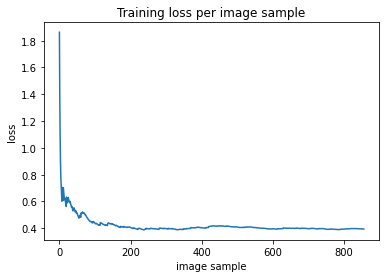

In [ ]:
plt.title("Training loss per image sample")
plt.ylabel("loss")
plt.xlabel("image sample")
plt.plot(x)

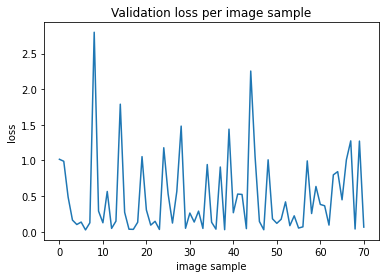

In [ ]:
validation_losses = pd.read_csv("loss_validation.txt")
x2 = validation_losses.values.tolist()
x2 = np.array(x2).reshape(71,)
y2 = np.arange(71)
plt.title("Validation loss per image sample")
plt.ylabel("loss")
plt.xlabel("image sample")
plt.plot(x2)